## Milk Production

In [0]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
milk = pd.read_csv('monthly-milk-production.csv', index_col = 'Month')

In [3]:
milk.head()

,Milk Production
Month,
1962-01-01 01:00:00,589.0
1962-02-01 01:00:00,561.0
1962-03-01 01:00:00,640.0
1962-04-01 01:00:00,656.0
1962-05-01 01:00:00,727.0


In [0]:
milk.index = pd.to_datetime(milk.index)

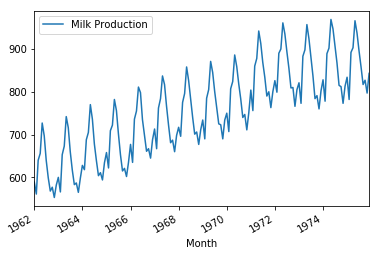

In [5]:
milk.plot()

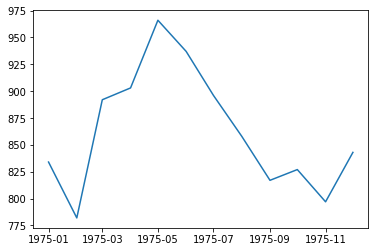

In [6]:
plt.plot(milk.index[-12:], milk.iloc[:, 0][-12:])

In [7]:
milk.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 168 entries, 1962-01-01 01:00:00 to 1975-12-01 01:00:00
Data columns (total 1 columns):
Milk Production    168 non-null float64
dtypes: float64(1)
memory usage: 2.6 KB


In [8]:
milk[-12:].shape, type(milk[-12:])

((12, 1), pandas.core.frame.DataFrame)

In [9]:
milk.tail(12).shape, type(milk.tail(12))

((12, 1), pandas.core.frame.DataFrame)

In [0]:
train_set = milk[:-12]
test_set = milk[-12:]

In [0]:
from sklearn.preprocessing import MinMaxScaler

In [0]:
scaler = MinMaxScaler()

In [0]:
train_scaled = scaler.fit_transform(train_set)
test_scaled = scaler.transform(test_set)

In [0]:
def next_batch(data_set, batch_size, steps, step_index):
    data = np.array(data_set).reshape(-1)
    period = data.shape[0]-steps
    batch_index = step_index%period
    y_batch = []
    for i in range(batch_size):
        y_batch.append(data[(batch_index+i)%period: (batch_index+i)%period+steps+1])
    
    y_batch = np.array(y_batch)  
    
    return y_batch[:, :-1].reshape(-1, steps, 1), y_batch[:, 1:].reshape(-1, steps, 1)


In [0]:
a, b = next_batch(train_set, 3, 5, 0)

In [16]:
a

array([[[589.],
        [561.],
        [640.],
        [656.],
        [727.]],

       [[561.],
        [640.],
        [656.],
        [727.],
        [697.]],

       [[640.],
        [656.],
        [727.],
        [697.],
        [640.]]])

In [0]:
num_inputs = 1
num_neurons = 90
num_outputs=1
learning_rate = 0.00001 
batch_size = 10
num_train_interations = 10000
num_layers = 3
num_time_steps = 24

In [0]:
tf.reset_default_graph()

In [0]:
x = tf.placeholder(tf.float32, [None, num_time_steps, num_inputs], name = 'x')
y = tf.placeholder(tf.float32, [None, num_time_steps, num_outputs])

In [0]:
def rnn_cell():
    cell = tf.contrib.rnn.BasicRNNCell(num_units = num_neurons, activation = tf.nn.leaky_relu)
    cell = tf.contrib.rnn.DropoutWrapper(cell, input_keep_prob=1.0, output_keep_prob=1.0, state_keep_prob=1.0)
    return cell
#create statcked rnn layers
stacked_rnn = tf.contrib.rnn.MultiRNNCell([rnn_cell() for _ in range(num_layers)])


In [0]:
cell = tf.contrib.rnn.OutputProjectionWrapper(stacked_rnn, output_size = num_outputs)


In [0]:
outputs, _ = tf.nn.dynamic_rnn(cell, x, dtype=tf.float32)
next_state = tf.identity(outputs, name='outputs_node')


In [0]:
loss = tf.reduce_mean(tf.square(outputs-y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train = optimizer.minimize(loss)

In [0]:
init = tf.global_variables_initializer()

In [0]:
saver = tf.train.Saver()

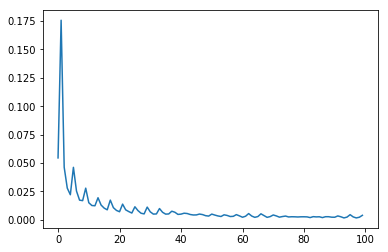

W0615 20:50:38.893389 139724759750528 legend.py:1289] No handles with labels found to put in legend.


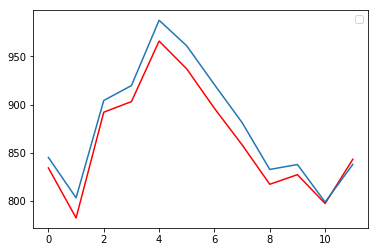

In [622]:
with tf.Session() as sess:
    sess.run(init)
    all_mse = []
    for iteration in range(num_train_interations):
    #for iteration in range(2):
        x_batch, y_batch = next_batch(train_scaled, batch_size, num_time_steps, iteration)
        sess.run(train, feed_dict={x:x_batch, y:y_batch})
        if iteration % 100 ==0:
            mse = loss.eval(feed_dict={x:x_batch, y:y_batch})
            all_mse.append(mse)
            #print (iteration, '\tMSE', mse)
    saver.save(sess, './time_series/ts_exercise')
    plt.plot(all_mse)
    plt.show()

    training_instance = train_scaled.reshape(-1)[-num_time_steps:]
    for iteration in range(12):
        x_new = training_instance[-num_time_steps:].reshape(1, -1).reshape(1, num_time_steps, num_inputs)
        prediction = sess.run(outputs, {x:x_new})[0, -1, 0]
        training_instance = np.append(training_instance, np.array([prediction]))
    predictions = scaler.inverse_transform(training_instance[-12:].reshape(-1, 1))
    plt.plot( np.array(milk.iloc[:, 0][-12:]), 'r-')
    plt.plot( predictions)
    plt.legend() 
    plt.show()

W0615 20:50:39.819581 139724759750528 legend.py:1289] No handles with labels found to put in legend.


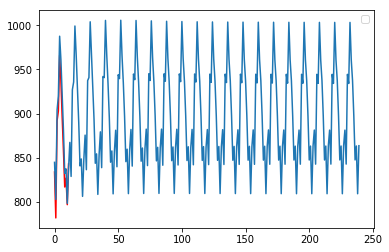

In [623]:
tf.reset_default_graph()
init=tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    saver = tf.train.import_meta_graph('./time_series/ts_exercise.meta')
    saver.restore(sess,tf.train.latest_checkpoint('./time_series/'))
    graph = tf.get_default_graph()
    x = graph.get_tensor_by_name('x:0')
    pred = graph.get_tensor_by_name('outputs_node:0')
    
    training_instance = train_scaled.reshape(-1)[-num_time_steps:]
    months_future = 120*2
    for iteration in range(months_future):
        x_new = training_instance[-num_time_steps:].reshape(1, -1).reshape(1, num_time_steps, num_inputs)
        prediction = sess.run(pred, {x:x_new})[0, -1, 0]
        training_instance = np.append(training_instance, np.array([prediction]))
    predictions = scaler.inverse_transform(training_instance[-months_future:].reshape(-1, 1))
    plt.plot( np.array(milk.iloc[:, 0][-12:]), 'r-')
    plt.plot( predictions)
    plt.legend() 
    plt.show()
    